# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from numba import njit
from scipy.linalg import eig
import warnings

In [5]:
# Suppress warnings (often arising from singular matrices in eig or Numba compilations)
warnings.filterwarnings('ignore')

In [6]:
def get_paper_strategies():
    """
    Generates the full strategy space for 10-bit strategies.
    Format: [Env1 (probs for 0..4 cooperators), Env2 (probs for 0..4 cooperators)]
    Bits represent deterministic moves (0=D, 1=C) based on local group cooperation levels.
    """
    num_bits = 10
    num_strats = 2**num_bits
    indices = np.arange(num_strats)
    # Vectorized bit extraction to create the strategy matrix
    strategies = ((indices[:, None] & (1 << np.arange(num_bits)[::-1])) > 0).astype(np.int64)
    return strategies

In [7]:
def calc_binom_matrix(N, n):
    """
    Pre-calculates the hypergeometric probability matrix.
    bm[M, k] is the probability that a group of size n chosen from population N
    contains exactly k mutants, given there are M mutants in the total population.
    """
    bm = np.zeros((N, n + 1))
    for M in range(N):
        for k in range(n + 1):
            total_ways = comb(N - 1, n - 1)
            if total_ways > 0:
                # Sampling logic: selecting k from M mutants and (n-1-k) from (N-1-M) residents
                # (One slot is fixed for the focal player)
                bm[M, k] = (comb(M, k) * comb(N - 1 - M, n - 1 - k)) / total_ways
    return bm

# Numba Accelerated Core

In [8]:
@njit(fastmath=True)
def solve_stationary(M):
    """Solves M.T * v = v for the stationary distribution v."""
    dim = M.shape[0]
    A = M.T - np.eye(dim)
    A[-1] = np.ones(dim) 
    b = np.zeros(dim)
    b[-1] = 1.0
    try:
        v = np.linalg.solve(A, b)
    except:
        v = np.ones(dim) / dim
    return v / np.sum(v)

@njit(fastmath=True)
def calc_pay_numba(strategies, k_threshold, r1, r2, c, epsilon):
    """Calculates payoffs and time in State 1 via Markov chain."""
    n = strategies.shape[0]
    num_states = 1 << (n + 1)
    str_prob = (1 - epsilon) * strategies + epsilon * (1 - strategies)

    M = np.zeros((num_states, num_states))
    pi_round = np.zeros((num_states, n))

    for row in range(num_states):
        current_env = (row >> n) & 1 
        actions = np.zeros(n, dtype=np.int64)
        nr_coop = 0
        for i in range(n):
            act = (row >> (n - 1 - i)) & 1
            actions[i] = act
            nr_coop += act

        mult = r1 if current_env == 0 else r2
        for j in range(n):
            pi_round[row, j] = (nr_coop * mult * c / n) - (actions[j] * c)

        next_env_val = 0 if nr_coop >= k_threshold else 1

        for next_row in range(num_states):
            if ((next_row >> n) & 1) == next_env_val:
                p_trans = 1.0
                for i in range(n):
                    s_idx = current_env * 5 + nr_coop
                    p_c = str_prob[i, s_idx]
                    next_act = (next_row >> (n - 1 - i)) & 1
                    p_trans *= p_c if next_act == 1 else (1.0 - p_c)
                M[row, next_row] = p_trans

    v = solve_stationary(M)
    pivec = np.zeros(n)
    avg_c, time_s1 = 0.0, 0.0
    
    for s in range(num_states):
        for j in range(n): pivec[j] += v[s] * pi_round[s, j]
        c_count = 0
        for b in range(n):
            if (s >> (n - 1 - b)) & 1: c_count += 1
        avg_c += v[s] * (c_count / n)
        if (s >> n) & 1 == 0: time_s1 += v[s]
            
    return pivec, avg_c, time_s1

@njit(fastmath=True)
def calc_rho(s1_idx, s2_idx, pay_pure, N, n, k_val, r1, r2, c, beta, bm, all_strats, eps):
    """Calculates fixation probability (Rho) for Mutant invading Resident."""
    pay = np.zeros((n + 1, 2))
    pay[n, 0], pay[0, 1] = pay_pure[s1_idx], pay_pure[s2_idx]

    for n_mut in range(1, n):
        group = np.zeros((n, 10), dtype=np.int64)
        for i in range(n_mut): group[i] = all_strats[s1_idx]
        for i in range(n_mut, n): group[i] = all_strats[s2_idx]
        pi_vec, _, _ = calc_pay_numba(group, k_val, r1, r2, c, eps)
        pay[n_mut, 0], pay[n_mut, 1] = pi_vec[0], pi_vec[n_mut]

    S = np.zeros(N)
    cumulative_diff = 0.0
    for i in range(1, N):
        f_i, g_i = 0.0, 0.0
        for k_nb in range(n):
            f_i += bm[i-1, k_nb] * pay[k_nb+1, 0]
            g_i += bm[i, k_nb] * pay[k_nb, 1]
        cumulative_diff += beta * (g_i - f_i)
        S[i] = cumulative_diff

    max_S = np.max(S)
    return (1.0 / np.sum(np.exp(S - max_S))) * np.exp(-max_S)

# Simulation Execution and Plotting

k=0 processed.
k=1 processed.
k=2 processed.
k=3 processed.
k=4 processed.


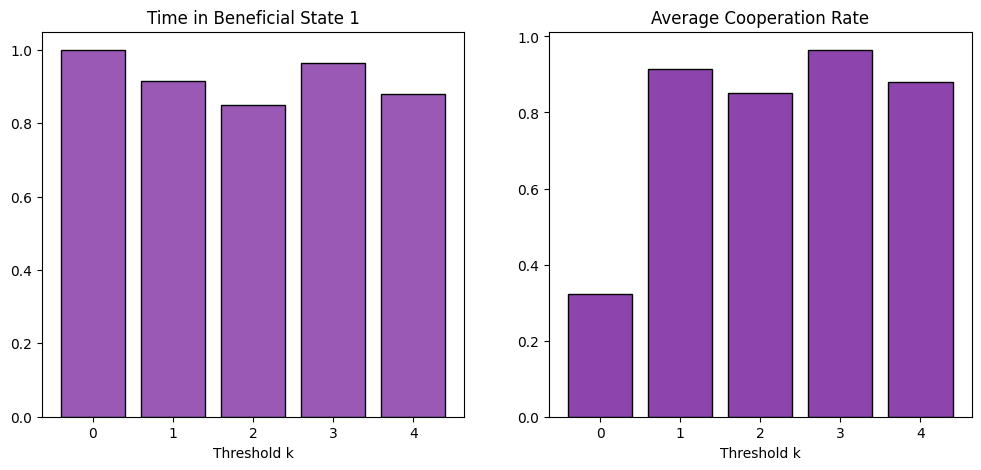

In [9]:
# Simulation Parameters
N, n, beta = 100, 4, 1.0 
r1, r2, c = 2.0, 0.5, 1.0 
eps = 0.0001

# Strategy Setup
all_strats_full = get_paper_strategies()
key_strategies = [
    [0]*10, [1]*10,                       # AllD, AllC
    [1,1,1,1,1, 0,0,0,0,1],               # Case E Repairer
    [1,1,1,1,1, 0,0,0,0,0]                # Grim Trigger
]
indices = np.random.choice(1024, 200, replace=False)
combined = [np.array(s) for s in key_strategies] + [all_strats_full[i] for i in indices]
all_strats = np.array(combined)
num_s = len(all_strats)
bm = calc_binom_matrix(N, n)

# Execution Loop
ks = [0, 1, 2, 3, 4] 
final_coop, final_s1 = [], []

for k_val in ks:
    pay_pure, coop_pure, time_pure = np.zeros(num_s), np.zeros(num_s), np.zeros(num_s)
    for i in range(num_s):
        group = np.repeat(all_strats[i:i+1], n, axis=0)
        pi, ac, ts1 = calc_pay_numba(group, k_val, r1, r2, c, eps)
        pay_pure[i], coop_pure[i], time_pure[i] = pi[0], ac, ts1

    trans_M = np.zeros((num_s, num_s))
    for j in range(num_s):
        for i in range(num_s):
            if i != j:
                rho = calc_rho(i, j, pay_pure, N, n, k_val, r1, r2, c, beta, bm, all_strats, eps)
                trans_M[j, i] = rho / (num_s - 1)
        trans_M[j, j] = 1.0 - np.sum(trans_M[j, :])

    vals, vecs = eig(trans_M.T)
    stat = vecs[:, np.argmin(np.abs(vals - 1.0))].real
    stat /= np.sum(stat)

    final_coop.append(np.dot(stat, coop_pure))
    final_s1.append(np.dot(stat, time_pure))
    print(f"k={k_val} processed.")

# Results Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(ks, final_s1, color='#9b59b6', edgecolor='black')
ax1.set_title('Time in Beneficial State 1')
ax1.set_xlabel('Threshold k')

ax2.bar(ks, final_coop, color='#8e44ad', edgecolor='black')
ax2.set_title('Average Cooperation Rate')
ax2.set_xlabel('Threshold k')
plt.show()